In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']

dict = {}

for cantonId in cantonKeys:
    d = pd.read_csv("data/merged/"+cantonId+".csv")
    d = d.set_index('Time')
    dict[cantonId] = d

display(len(dict))




26

In [22]:
for col in dict['AG'].columns:
    print(col)

Cases entries 0 - 9
Cases entries 10 - 19
Cases entries 20 - 29
Cases entries 30 - 39
Cases entries 40 - 49
Cases entries 50 - 59
Cases entries 60 - 69
Cases entries 70 - 79
Cases entries 80+
Cases entries Unbekannt
Cases prct 0 - 9
Cases prct 10 - 19
Cases prct 20 - 29
Cases prct 30 - 39
Cases prct 40 - 49
Cases prct 50 - 59
Cases prct 60 - 69
Cases prct 70 - 79
Cases prct 80+
Cases prct Unbekannt
Cases inz_entries 0 - 9
Cases inz_entries 10 - 19
Cases inz_entries 20 - 29
Cases inz_entries 30 - 39
Cases inz_entries 40 - 49
Cases inz_entries 50 - 59
Cases inz_entries 60 - 69
Cases inz_entries 70 - 79
Cases inz_entries 80+
Cases inz_entries Unbekannt
Cases inzsumTotal 0 - 9
Cases inzsumTotal 10 - 19
Cases inzsumTotal 20 - 29
Cases inzsumTotal 30 - 39
Cases inzsumTotal 40 - 49
Cases inzsumTotal 50 - 59
Cases inzsumTotal 60 - 69
Cases inzsumTotal 70 - 79
Cases inzsumTotal 80+
Cases inzsumTotal Unbekannt
Death entries 0 - 9
Death entries 10 - 19
Death entries 20 - 29
Death entries 30 - 39


/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Time'>

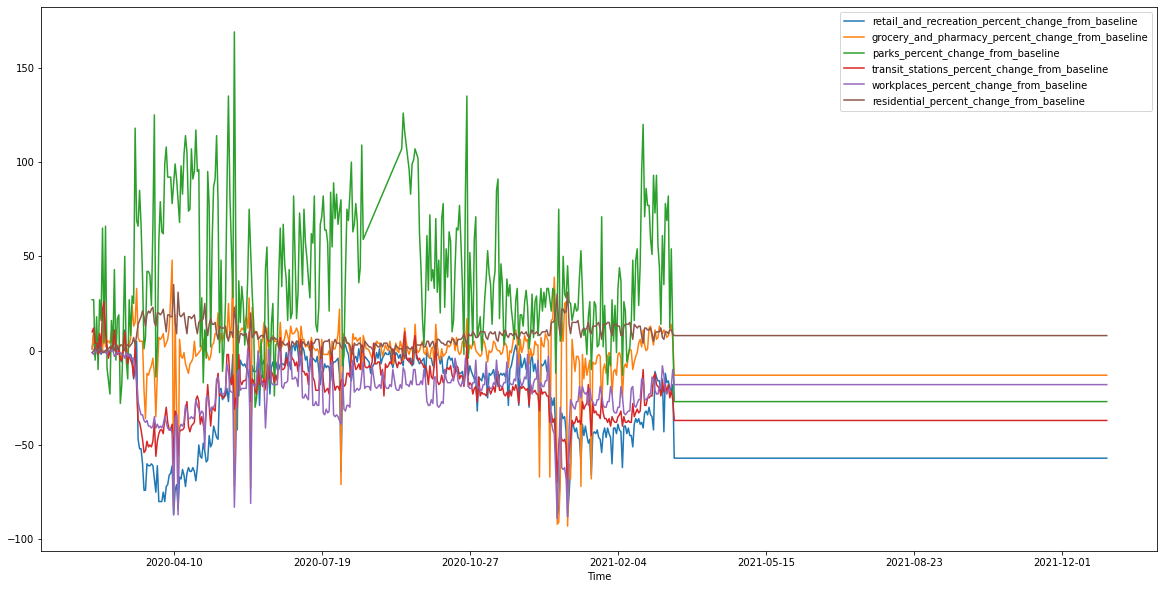

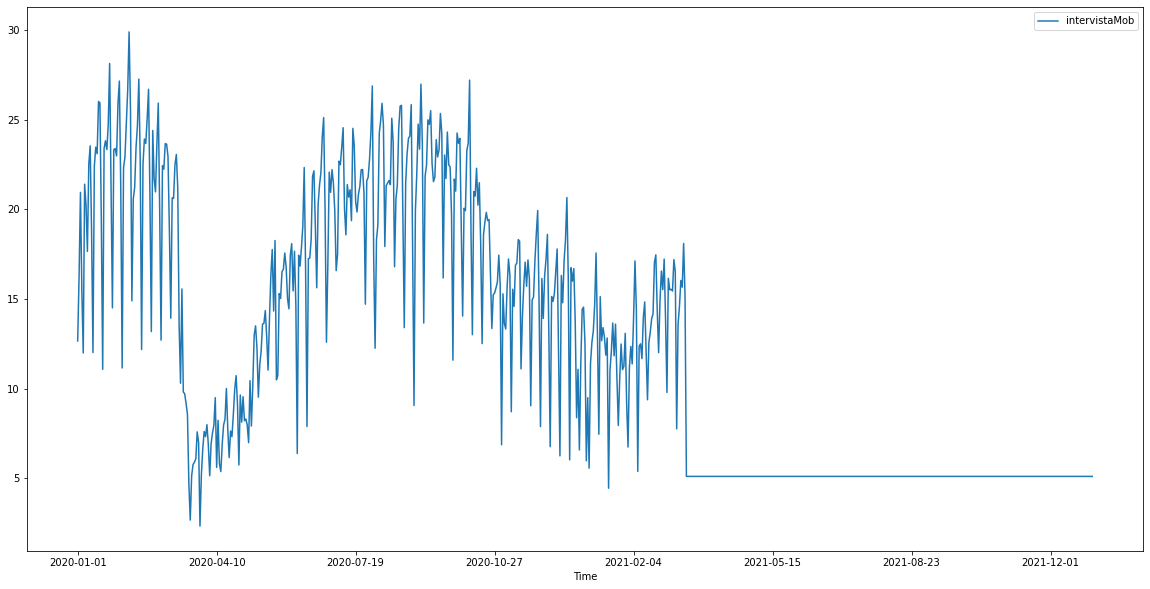

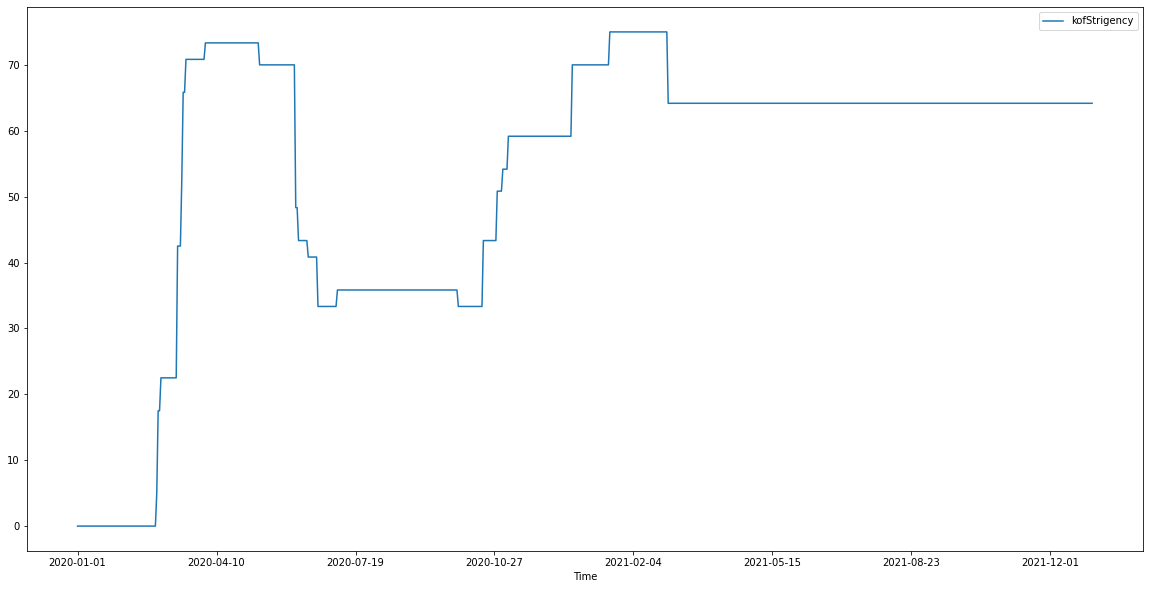

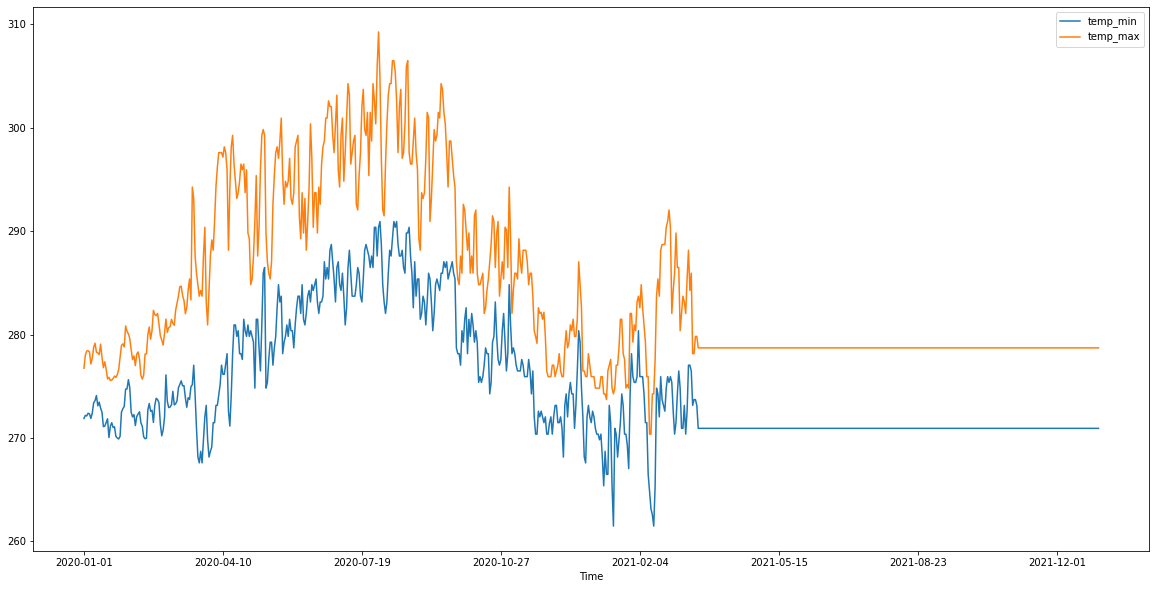

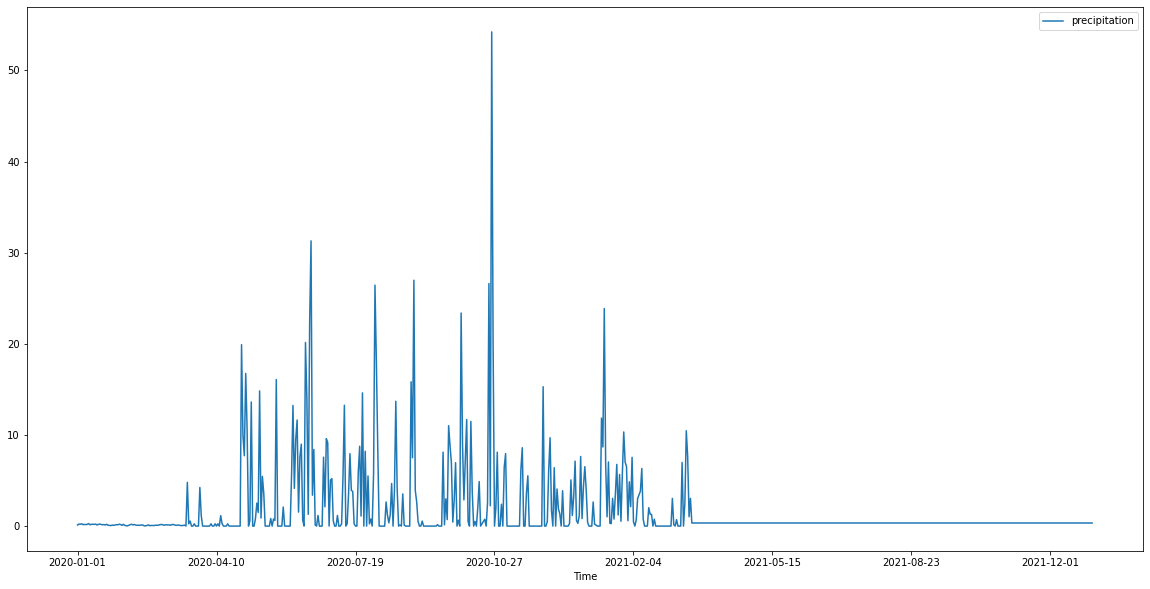

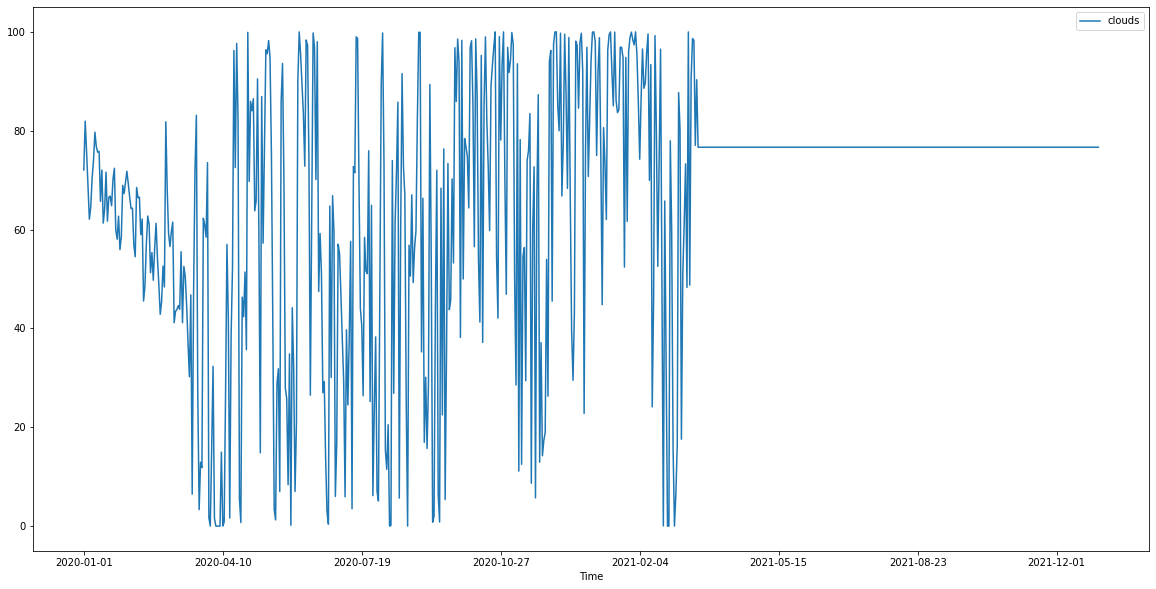

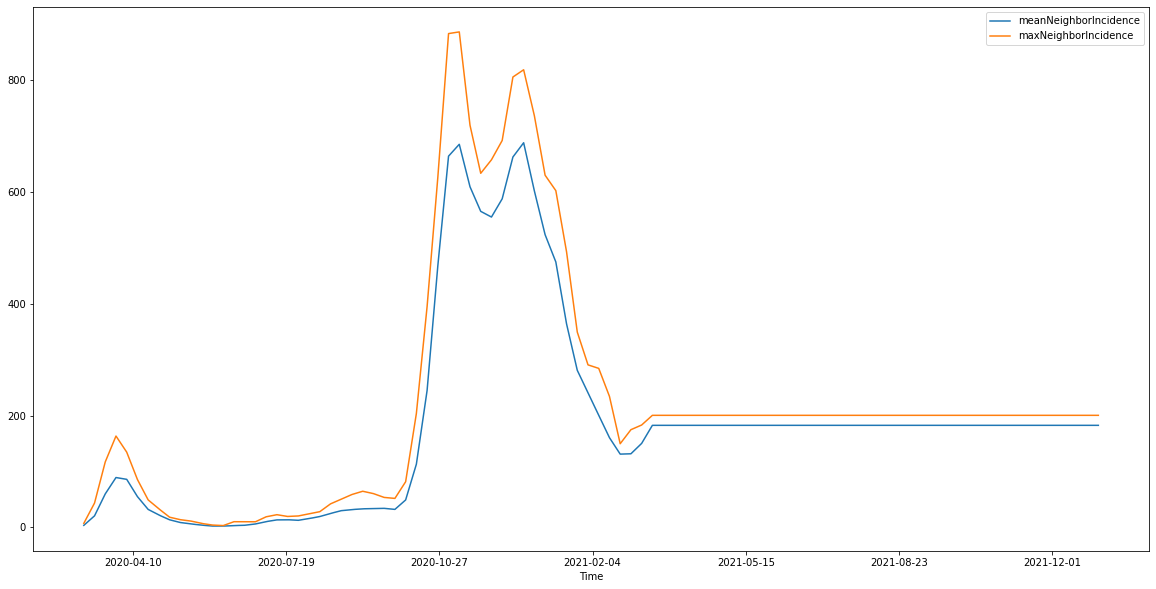

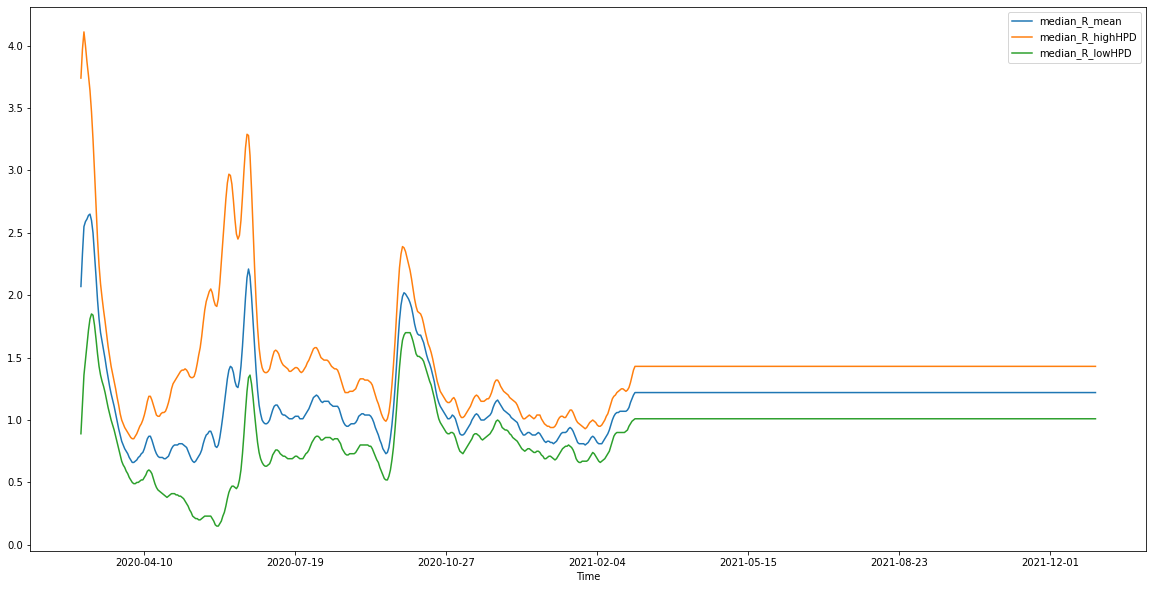

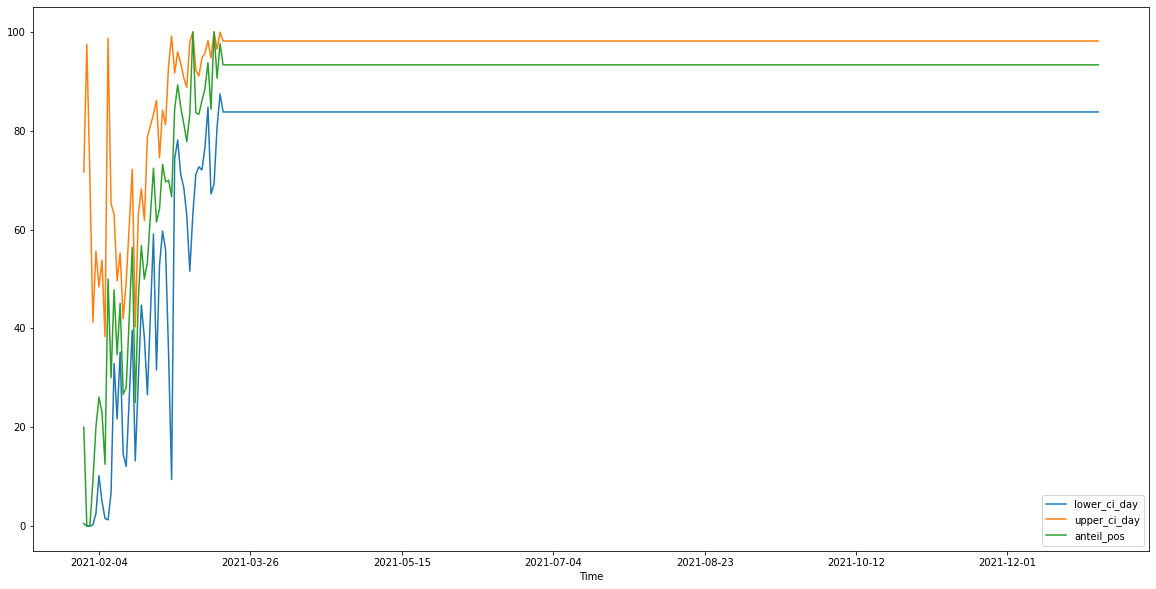

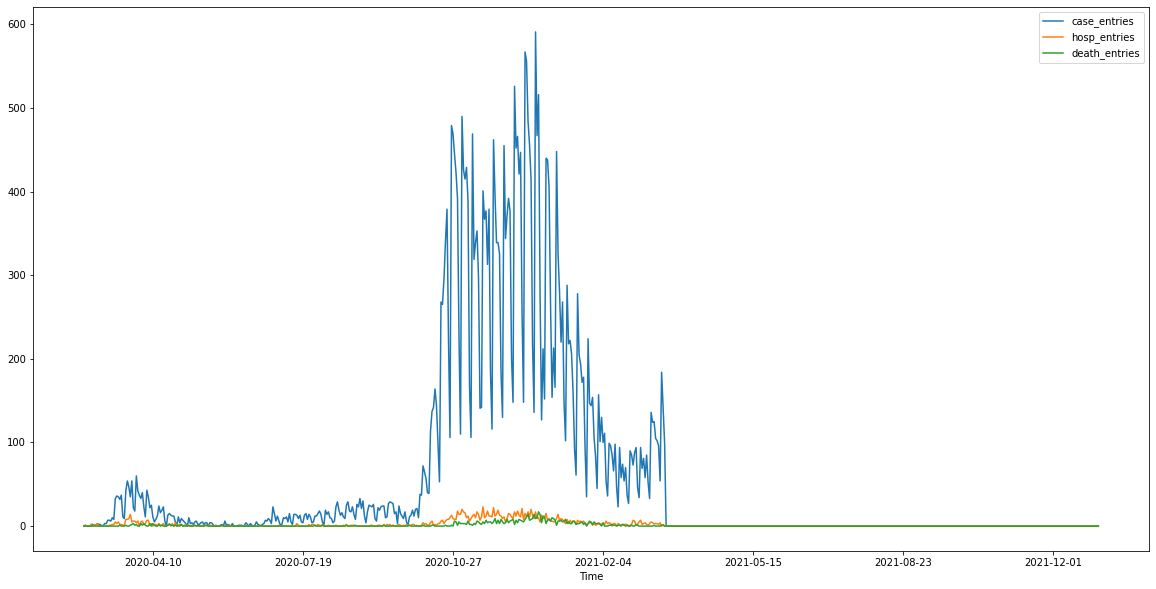

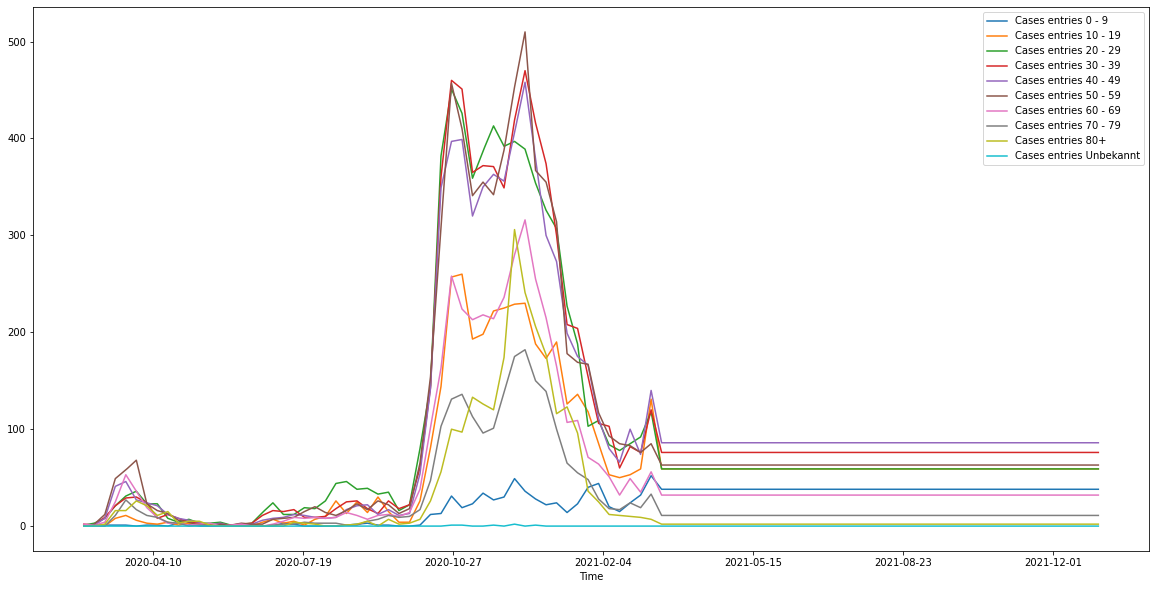

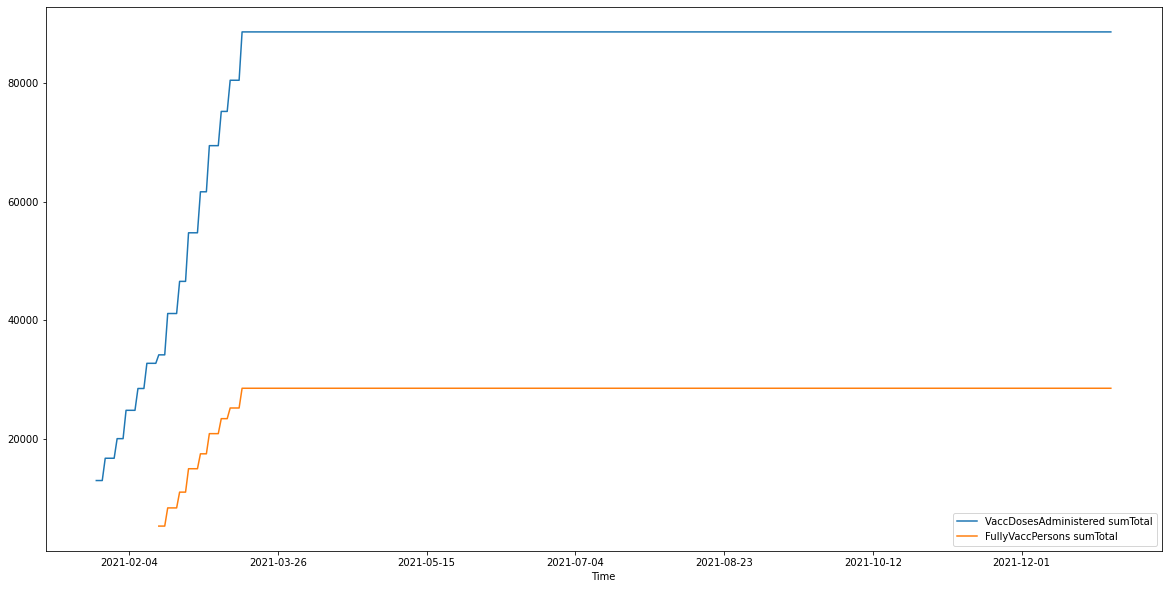

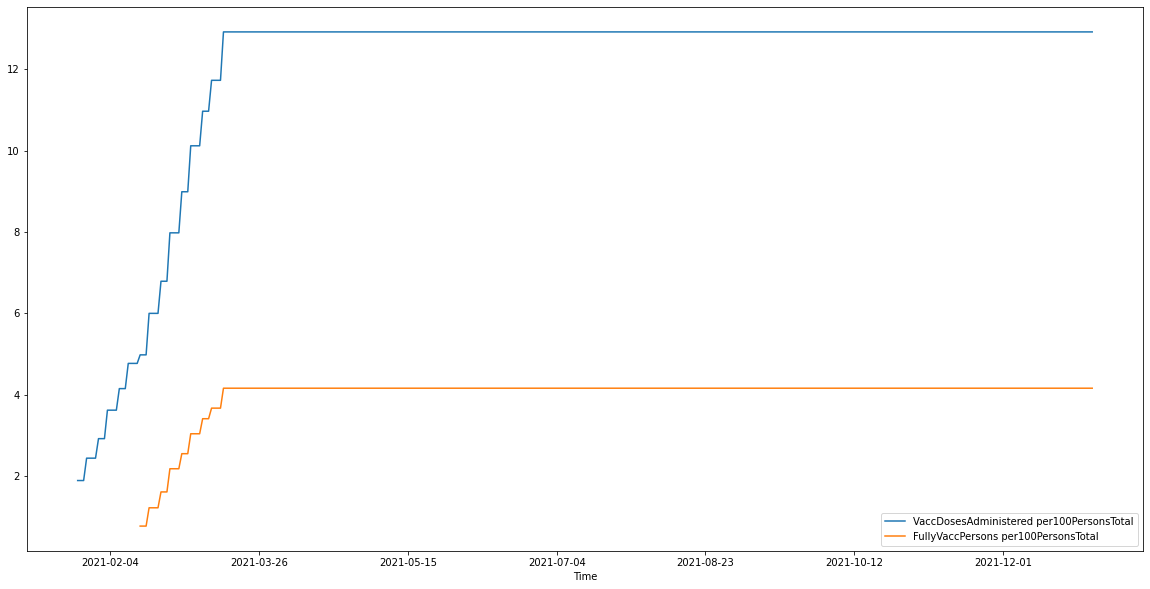

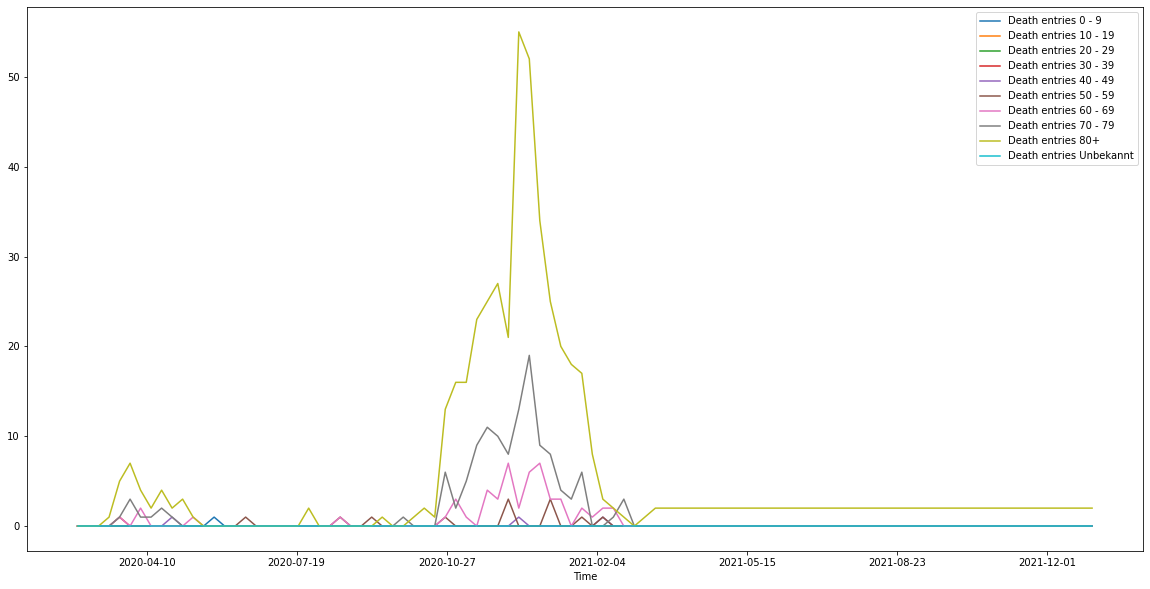

In [32]:
# exploring google mobility data

plotDict = {}

plotDict['googleMob'] = ['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline',
'parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline',
'workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']

plotDict['intervistaMob'] = ['intervistaMob']

plotDict['kof'] = ['kofStrigency']

plotDict['temperature'] = ['temp_min','temp_max']

plotDict['precipitation'] = ['precipitation']

plotDict['clouds'] =['clouds']

plotDict['neigbohr'] = ['meanNeighborIncidence','maxNeighborIncidence']

plotDict['rvalue'] = ['median_R_mean','median_R_highHPD','median_R_lowHPD']

plotDict['variant'] = ['lower_ci_day','upper_ci_day','anteil_pos']

plotDict['entries'] = ['case_entries','hosp_entries','death_entries']

plotDict['cases_agegroup'] = ['Cases entries 0 - 9','Cases entries 10 - 19','Cases entries 20 - 29','Cases entries 30 - 39',
                          'Cases entries 40 - 49','Cases entries 50 - 59','Cases entries 60 - 69','Cases entries 70 - 79',
                          'Cases entries 80+','Cases entries Unbekannt']

plotDict['vaccineSum'] = ['VaccDosesAdministered sumTotal','FullyVaccPersons sumTotal']

plotDict['vaccinePer100Person'] = ['VaccDosesAdministered per100PersonsTotal','FullyVaccPersons per100PersonsTotal']

plotDict['death'] = ['Death entries 0 - 9','Death entries 10 - 19','Death entries 20 - 29','Death entries 30 - 39',
                     'Death entries 40 - 49','Death entries 50 - 59','Death entries 60 - 69','Death entries 70 - 79',
                     'Death entries 80+','Death entries Unbekannt']

for colsOfInterest in plotDict:
    display(dict['AG'][plotDict[colsOfInterest]].interpolate(method='linear').plot(kind='line', y=plotDict[colsOfInterest], figsize=(20,10)))
    #.rolling(window=7).mean()